In [4]:
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import datetime
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
warnings.filterwarnings('ignore')

In [8]:
student_por_df = pd.read_csv('student-por.csv', sep = ';')
student_por_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [10]:
student_por_df['G3'].describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

In [11]:
student_por_df.shape

(649, 33)

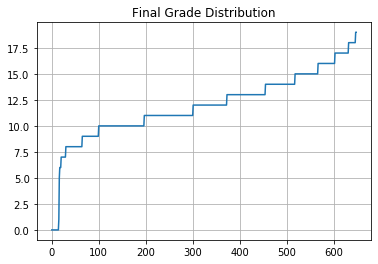

In [12]:
plt.plot(sorted(student_por_df['G3']))
plt.title("Final Grade Distribution")
plt.grid()

In [15]:
student_math_df = pd.read_csv('student-mat.csv', sep = ';')
student_math_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [18]:
student_math_df['G3'].describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

In [19]:
student_math_df.shape

(395, 33)

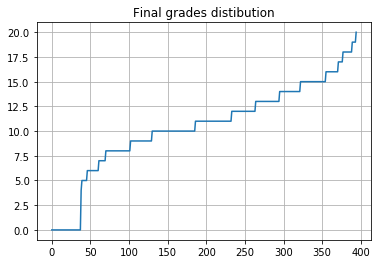

In [20]:
plt.plot(sorted(student_math_df['G3']))
plt.title('Final grades distibution')
plt.grid()
plt.show()

### We are going to use math data becuase it has less number of rows, to be a good model our model should be trained with larger data so with 
### Stick with portuges data

# Exploration and Feature Engineering

In [23]:
# Find all non numerical data
non_numeric_features = [feat for feat in list(student_por_df) if feat not in list(student_por_df._get_numeric_data())]
for feat in non_numeric_features:
    print(feat, ':', set(student_por_df[feat]))

school : {'GP', 'MS'}
sex : {'F', 'M'}
address : {'U', 'R'}
famsize : {'GT3', 'LE3'}
Pstatus : {'T', 'A'}
Mjob : {'teacher', 'at_home', 'other', 'health', 'services'}
Fjob : {'at_home', 'teacher', 'health', 'other', 'services'}
reason : {'course', 'reputation', 'other', 'home'}
guardian : {'mother', 'other', 'father'}
schoolsup : {'no', 'yes'}
famsup : {'no', 'yes'}
paid : {'no', 'yes'}
activities : {'no', 'yes'}
nursery : {'no', 'yes'}
higher : {'no', 'yes'}
internet : {'no', 'yes'}
romantic : {'no', 'yes'}


In [39]:
# Break this out in their seperate columns


In [28]:
for feat in non_numeric_features:
    dummies = pd.get_dummies(student_por_df[feat]).rename(columns=lambda x: feat + '_' + str(x))
    student_por_df = pd.concat([student_por_df, dummies], axis=1)
    
student_por_df = student_por_df[[feat for feat in list(student_por_df) if feat not in non_numeric_features]]

In [30]:
student_por_df.shape

(649, 59)

In [31]:
student_por_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


# Modeling with XGBoost

In [41]:
# Create an xgboost model
# run simple xgboost classification model and check

outcome = 'G3'
features = [feat for feat in list(student_por_df) if feat not in outcome]
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(student_por_df, student_por_df[outcome], test_size = 0.3 , random_state = 42)

In [46]:
import xgboost  as xgb
xgb_params = {
    'eta':0.01,
    'max_depth':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'seed':0
}

In [49]:
# xgb wants data int martices
dtrain = xgb.DMatrix(X_train[features], y_train, feature_names = features)
dtest = xgb.DMatrix(X_test[features], y_test, feature_names = features)
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params = xgb_params, 
                     dtrain = dtrain,
                     num_boost_round = 2000, 
                     verbose_eval = 50,
                     early_stopping_rounds = 500, 
                     evals = evals,
                     maximize = False)

[14:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:11.64971	eval-rmse:11.94302
[50]	train-rmse:7.20058	eval-rmse:7.40624
[100]	train-rmse:4.50631	eval-rmse:4.63594
[150]	train-rmse:2.90725	eval-rmse:2.99138
[200]	train-rmse:1.98567	eval-rmse:2.06537
[250]	train-rmse:1.47358	eval-rmse:1.56771
[300]	train-rmse:1.20603	eval-rmse:1.32743
[350]	train-rmse:1.06527	eval-rmse:1.22792
[400]	train-rmse:0.98898	eval-rmse:1.19130
[450]	train-rmse:0.94039	eval-rmse:1.17599
[500]	train-rmse:0.90536	eval-rmse:1.16880
[550]	train-rmse:0.87610	eval-rmse:1.16890
[600]	train-rmse:0.85171	eval-rmse:1.17095
[650]	train-rmse:0.83189	eval-rmse:1.17157
[700]	train-rmse:0.81395	eval-rmse:1.17366
[750]	train-rmse:0.79626	eval-rmse:1.17288
[800]	train-rmse:0.77829	eval-rmse:1.17525
[850]	train-rmse:0.76304	eval-rmse:1.17549
[900]	train-rmse:0.74792	eval-rmse:1.17686
[950]	t

# Building an actionable Report

### Find poor performing students and find out why they are so compared to their peers
### Plot the important figures


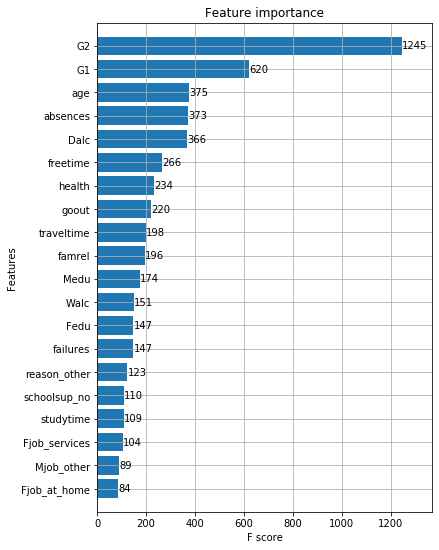

In [53]:
fig, ax = plt.subplots(figsize=(6,9))
xgb.plot_importance(xgb_model,  height=0.8, ax=ax, max_num_features=20)

plt.show()

In [54]:
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
xgb_fea_imp.head(10)

,feature,importance
0,G2,1245
1,G1,620
11,age,375
8,absences,373
5,Dalc,366
15,freetime,266
13,health,234
29,goout,220
38,traveltime,198
10,famrel,196


In [55]:
print(xgb_model.predict(dtest)[0:10])


[16.81228  11.550355 17.011883 11.075317 11.513776 16.314234 17.202694
 10.227154 10.89279  10.709687]


In [56]:
key_features = list(xgb_fea_imp['feature'].values[0:40])
key_features

['G2',
 'G1',
 'age',
 'absences',
 'Dalc',
 'freetime',
 'health',
 'goout',
 'traveltime',
 'famrel',
 'Medu',
 'Walc',
 'Fedu',
 'failures',
 'reason_other',
 'schoolsup_no',
 'studytime',
 'Fjob_services',
 'Mjob_other',
 'Fjob_at_home',
 'sex_F',
 'famsup_no',
 'school_GP',
 'guardian_father',
 'romantic_no',
 'Mjob_services',
 'Mjob_teacher',
 'famsize_GT3',
 'higher_no',
 'nursery_no',
 'activities_no',
 'reason_reputation',
 'reason_home',
 'internet_no',
 'reason_course',
 'address_R',
 'schoolsup_yes',
 'paid_no',
 'guardian_mother',
 'school_MS']

In [57]:
# Take students with a predicted final score of less than 10 over 20
predicted_students_in_trouble = X_test[X_test['G3'] < 10]

# See which feature they landed well below or well above peers
for index, row in predicted_students_in_trouble.iterrows():
    print('Student ID:', index)
    for feat in key_features:
        if row[feat] < student_por_df[feat].quantile(0.25):
            print('\t', 'Below:', feat, row[feat], 'Class:', 
                  np.round(np.mean(student_por_df[feat]),2))
        if row[feat] > student
        _por_df[feat].quantile(0.75):
            print('\t','Above:', feat, row[feat], 'Class:', 
                  np.round(np.mean(student_por_df[feat]),2))

Student ID: 131
	 Below: G2 9 Class: 11.57
	 Above: absences 10 Class: 3.66
	 Above: goout 5 Class: 3.18
	 Above: failures 3 Class: 0.22
	 Above: Mjob_services 1 Class: 0.21
	 Above: higher_no 1 Class: 0.11
	 Above: reason_reputation 1 Class: 0.22
Student ID: 81
	 Below: G2 9 Class: 11.57
	 Below: age 15 Class: 16.74
	 Below: schoolsup_no 0 Class: 0.9
	 Above: studytime 3 Class: 1.93
	 Above: nursery_no 1 Class: 0.2
	 Above: reason_home 1 Class: 0.23
	 Above: schoolsup_yes 1 Class: 0.1
Student ID: 585
	 Below: G2 7 Class: 11.57
	 Below: G1 8 Class: 11.4
	 Below: freetime 2 Class: 3.18
	 Above: studytime 3 Class: 1.93
	 Above: Fjob_at_home 1 Class: 0.06
	 Above: higher_no 1 Class: 0.11
	 Above: internet_no 1 Class: 0.23
	 Below: paid_no 0 Class: 0.94
Student ID: 177
	 Below: G2 8 Class: 11.57
	 Below: G1 9 Class: 11.4
	 Below: Medu 1 Class: 2.51
	 Above: Walc 4 Class: 2.28
	 Above: failures 1 Class: 0.22
	 Above: guardian_father 1 Class: 0.24
	 Above: higher_no 1 Class: 0.11
Student ID:

# Let's create a better looking report to share our findings

Student ID: 131


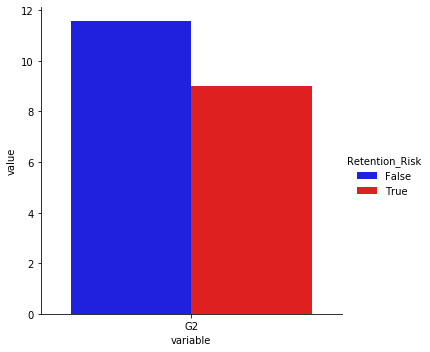

Student ID: 81


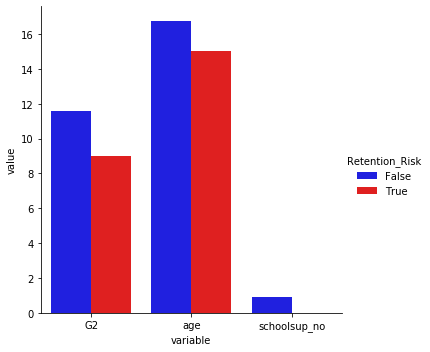

Student ID: 585


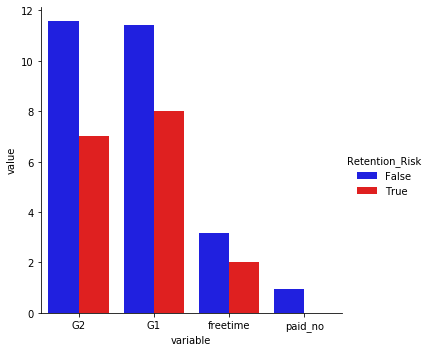

Student ID: 177


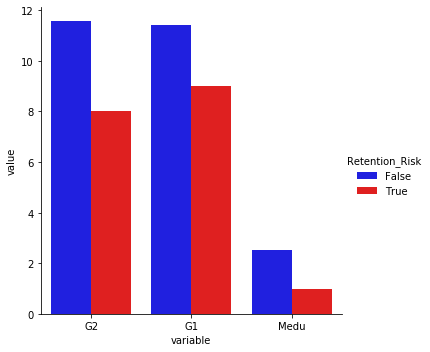

Student ID: 174


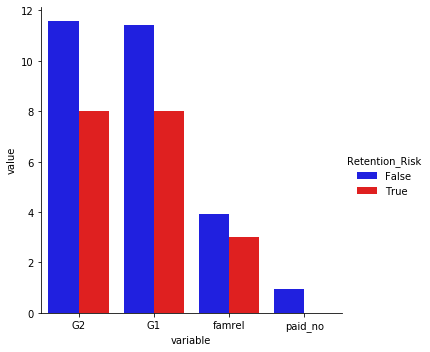

Student ID: 478


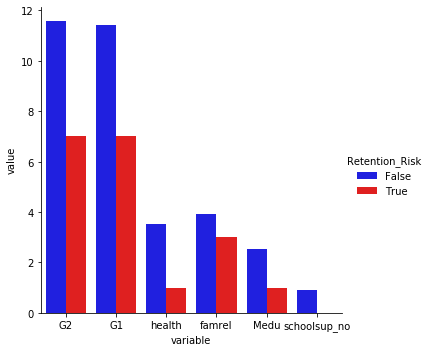

Student ID: 522


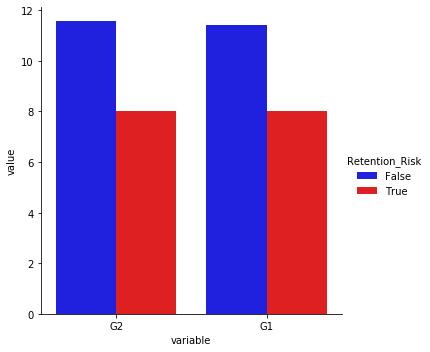

Student ID: 163


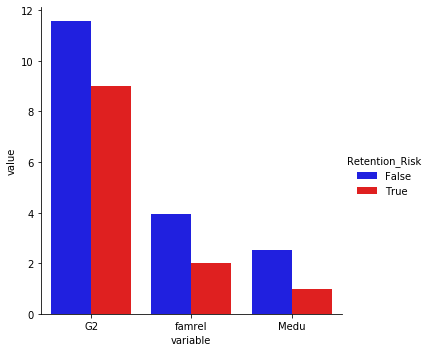

Student ID: 570


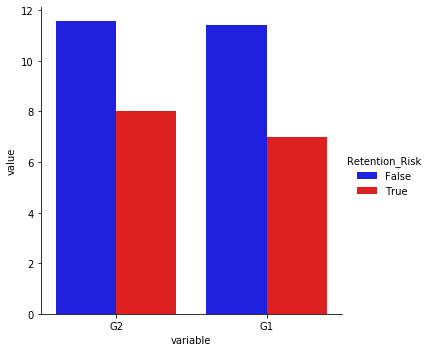

Student ID: 257


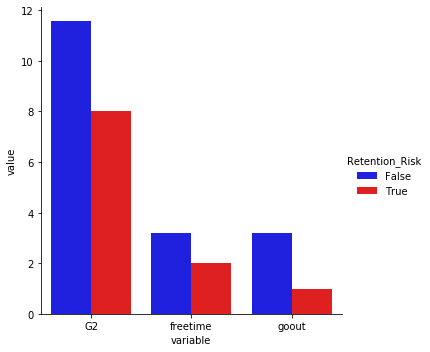

Student ID: 148


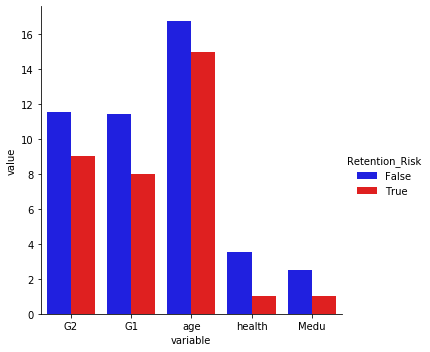

Student ID: 447


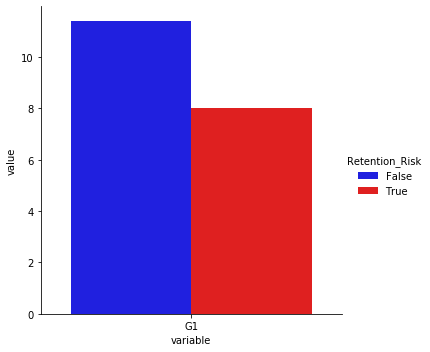

Student ID: 518


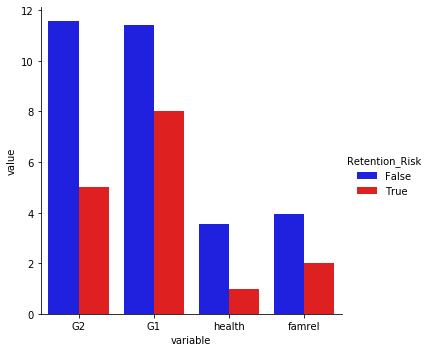

Student ID: 603


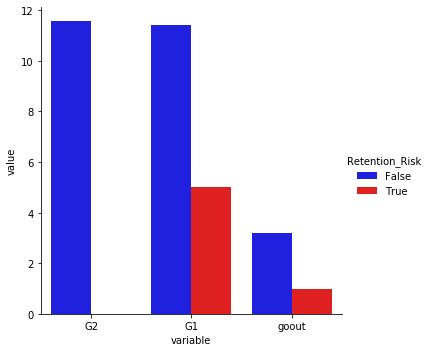

Student ID: 514


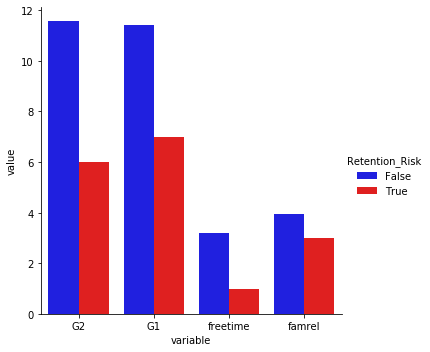

Student ID: 568


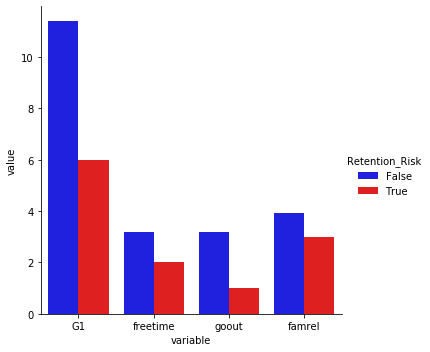

Student ID: 440


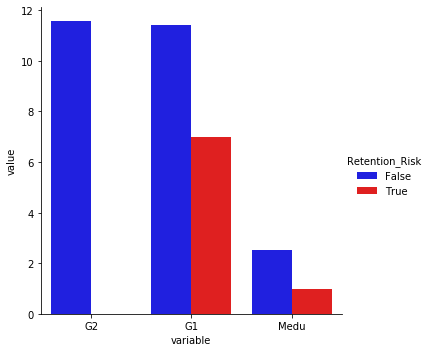

Student ID: 443


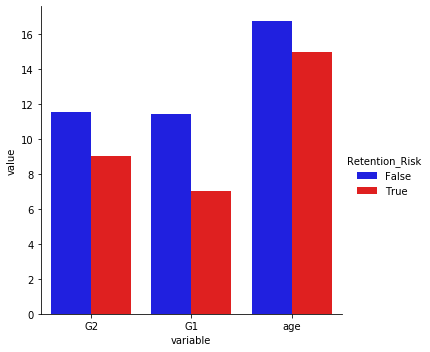

Student ID: 155


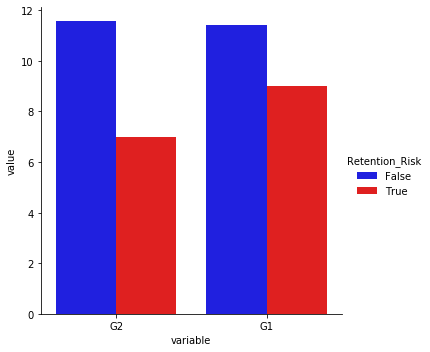

Student ID: 248


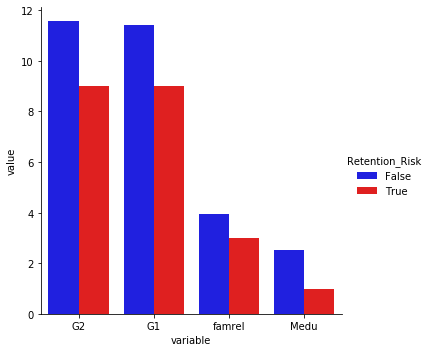

Student ID: 494


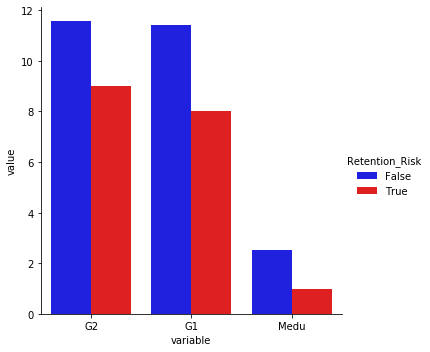

Student ID: 563


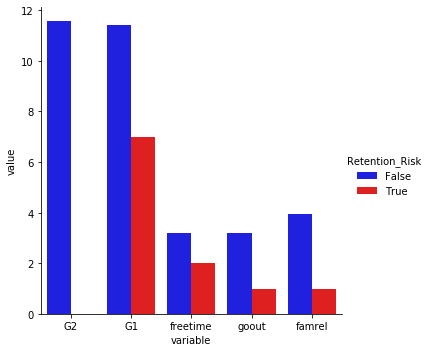

Student ID: 432


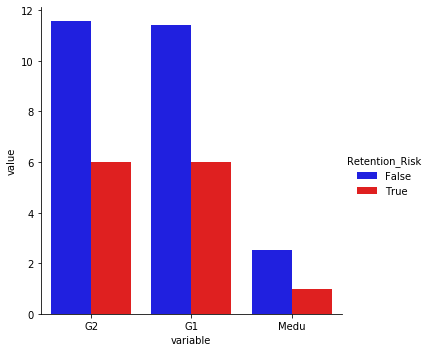

Student ID: 583


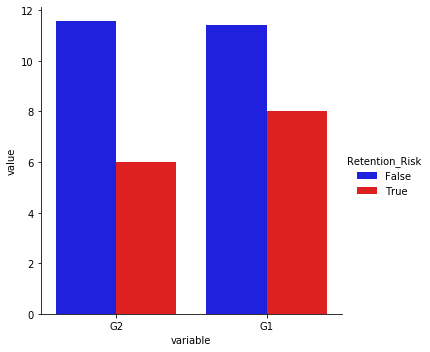

Student ID: 370


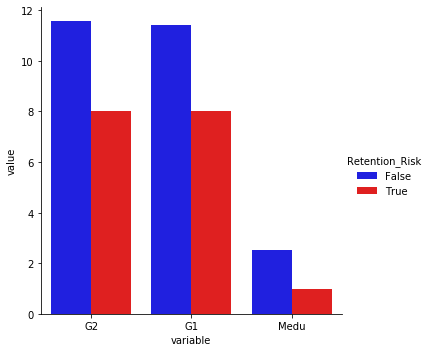

Student ID: 256


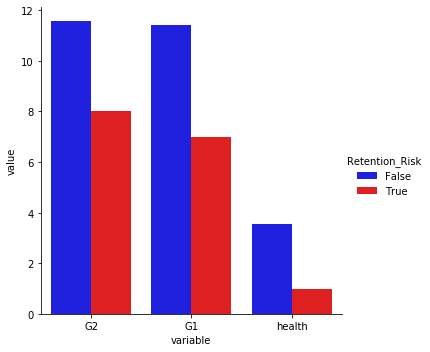

In [58]:
lower_limit_threshold = 0.25

# See which feature they landed well below or well above peers
for index, row in predicted_students_in_trouble.iterrows():
    student_id = index
    important_low_features = []
 
    for feat in key_features:
        if row[feat] < student_por_df[feat].quantile(lower_limit_threshold):
            important_low_features.append(feat)
    
    # create new data set for this student
    at_risk_student = pd.DataFrame(row[important_low_features]).T
    at_risk_student['Retention_Risk'] = True
    student_mean = pd.DataFrame(student_por_df[important_low_features].mean(axis=0)).T
    student_mean['Retention_Risk'] = False
    student_profile = pd.concat([at_risk_student,student_mean])
    student_profile = pd.melt(student_profile, id_vars="Retention_Risk")
    
    print('Student ID:', student_id)
    sns.catplot(x='variable', y='value', hue='Retention_Risk',data=student_profile, kind='bar', 
                palette=sns.color_palette(['blue', 'red']))

    plt.show()